In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import PandasTools
import tqdm
import torch
from torch import nn
import functools
import requests as req

In [13]:
HERE = Path(".").absolute()
DATA = HERE / "data"

In [14]:
kinodata = pd.read_csv(DATA / "activities-chembl31.csv.gz", index_col=0)
kinodata.set_index("activities.activity_id", inplace=True)
docking_info = pd.read_csv(DATA / "docking_information.csv.gz", index_col="ident")
structure_ids = pd.read_csv(DATA / "klifs_structures.csv.gz", index_col="activities.activity_id")
docking_info = kinodata.merge(
    docking_info, left_index=True, right_index=True, suffixes=("", "")
).merge(structure_ids, left_index=True, right_index=True, suffixes=("", ""))
most_similar = pd.read_csv(DATA / "most_similar.csv.gz", index_col="activities.activity_id")
docking_info = docking_info.join(most_similar)
# filter multi-compound smiles
docking_info = docking_info[
    ~docking_info["compound_structures.canonical_smiles"].str.contains("\.")
]

In [ ]:
molecules = []
for ident, row in tqdm.tqdm(docking_info.iterrows(), total=len(docking_info)):
    filepath = Path(f"../docking/similar_pdbs/results/poses/{ident}.sdf")
    if filepath.exists():
        suppl = Chem.SDMolSupplier(str(filepath))
        assert len(suppl) == 1, ident
        for mol in suppl:
            molecules.append(mol)
    else:
        molecules.append(None)

 74%|█████████████████████████████████████████████████████████████▉                      | 92877/125958 [01:16<00:22, 1466.57it/s]

In [11]:
len(docking_info
   )

125952

In [7]:
docking_info.loc[:, "molecule"] = molecules

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
print(docking_info["molecule"].isna().sum(), "sdf files are missing?!")
docking_info = docking_info[~docking_info["molecule"].isna()]

In [7]:
docking_info.head()

,assays.chembl_id,target_dictionary.chembl_id,molecule_dictionary.chembl_id,molecule_dictionary.max_phase,activities.standard_type,activities.standard_value,activities.standard_units,compound_structures.canonical_smiles,compound_structures.standard_inchi,component_sequences.sequence,...,docking.chemgauss_score,docking.posit_probability,docking.duration,similar.klifs_structure_id,similar.ligand_pdb,similar.complex_pdb,similar.chain,similarity,similar.fp_similarity,molecule
32336,CHEMBL847682,CHEMBL4128,CHEMBL69638,0,pIC50,5.468521,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,MDSLASLVLCGVSLLLSGTVEGAMDLILINSLPLVSDAETSLTCIA...,...,-10.307055,0.24,62.318077,5553.0,QQ1,2WQB,A,0.298246,0.298246,<rdkit.Chem.rdchem.Mol object at 0x7ff160e82be0>
32770,CHEMBL674643,CHEMBL203,CHEMBL306988,0,pIC50,3.301030,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,InChI=1S/C15H13N3O3/c1-10(12(8-16)9-17)11-2-4-...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,...,-8.572478,0.05,83.548552,10374.0,FZP,6D8E,A,0.232877,0.232877,<rdkit.Chem.rdchem.Mol object at 0x7ff160e82ca0>
33033,CHEMBL812621,CHEMBL279,CHEMBL419526,0,pIC50,5.725842,nM,c1ccc(-c2cnc(Nc3ccccn3)o2)cc1,InChI=1S/C14H11N3O/c1-2-6-11(7-3-1)12-10-16-14...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,...,-12.837239,0.05,513.319727,7065.0,6NC,5JT2,A,0.142857,0.142857,<rdkit.Chem.rdchem.Mol object at 0x7ff160e82c40>
33375,CHEMBL664848,CHEMBL3142,CHEMBL104450,0,pIC50,6.455932,nM,O=c1cc(-c2cccc(-c3ccc(O)cc3)c2)sc(N2CCOCC2)c1,InChI=1S/C21H19NO3S/c23-18-6-4-15(5-7-18)16-2-...,MAGSGAGVRCSLLRLQETLSAADRCGAALAGHQLIRGLGQECVLSS...,...,-13.835115,0.18,71.917884,2316.0,07U,3TXO,A,0.163636,0.163636,<rdkit.Chem.rdchem.Mol object at 0x7ff160e82b80>
34276,CHEMBL812621,CHEMBL279,CHEMBL330621,0,pIC50,7.721246,nM,Cc1ccc(Nc2ncc(-c3ccccc3)s2)nc1,InChI=1S/C15H13N3S/c1-11-7-8-14(16-9-11)18-15-...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,...,-8.804253,0.18,71.689741,5323.0,AAZ,1Y6A,A,0.400000,0.400000,<rdkit.Chem.rdchem.Mol object at 0x7ff160e82b20>


In [13]:
model = torch.load('/home/michael/Code/kinase-docking-benchmark/pose_quality_model.pt')

In [26]:
X = torch.from_numpy(docking_info[['docking.posit_probability', 'docking.chemgauss_score', 'similar.fp_similarity']].values.astype(np.float32))
with torch.no_grad():
    predicted_rmsd = model(X)

In [29]:
docking_info['docking.predicted_rmsd'] = predicted_rmsd

In [68]:
docking_info.drop('similarity', inplace=True, errors='ignore')

In [49]:
class KLIFSLookup:
    def __init__(self):
        self.cache = dict()
        self.ligand_cache = dict()

    def get_ligand_pdbs(self, structure_id):
        if structure_id in self.cache:
            return self.cache[structure_id]
        resp = req.get('https://klifs.net/api_v2/structure_list', {'structure_ID': structure_id})
        resp.raise_for_status()
        self.cache[structure_id] = [entry['ligand'] for entry in resp.json()]
        return self.get_ligand_pdbs(structure_id)
    
    def get_ligand_chembl_id(self, pdb_id):
        if pdb_id in self.ligand_cache:
            return self.ligand_cache[pdb_id]
        resp = req.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/compound/summary/{pdb_id}')
        resp.raise_for_status()
        chembl_id = resp.json()[pdb_id][0]['chembl_id']
        self.ligand_cache[pdb_id] = chembl_id
        return self.get_ligand_chembl_id(pdb_id)

In [50]:
lookup = KLIFSLookup()

In [59]:
is_in_klifs = list()
for _, row in tqdm.tqdm(docking_info.iterrows(), total=len(docking_info)):
    try:
        pdbs = lookup.get_ligand_pdbs(row['similar.klifs_structure_id'])
        flag = any(row['molecule_dictionary.chembl_id'] == lookup.get_ligand_chembl_id(pdb) for pdb in pdbs)
        is_in_klifs.append(flag)
    except:
        is_in_klifs.append(None)

100%|████████████████████████████████████████████████████████████████████████████████████| 125952/125952 [07:10<00:00, 292.81it/s]


In [60]:
is_in_klifs = np.array(is_in_klifs)

In [64]:
(is_in_klifs == False).sum()

124761

In [66]:
docking_info['is_in_klifs'] = is_in_klifs

In [74]:
docking_info.drop(columns=['similarity'], inplace=True)

In [79]:
docking_info = docking_info[docking_info['is_in_klifs'] == False]

In [82]:
docking_info.drop(columns=['is_in_klifs'], inplace=True)

/tmp/ipykernel_18119/1513567874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docking_info.drop(columns=['is_in_klifs'], inplace=True)


In [83]:
docking_info.columns

Index(['assays.chembl_id', 'target_dictionary.chembl_id',
       'molecule_dictionary.chembl_id', 'molecule_dictionary.max_phase',
       'activities.standard_type', 'activities.standard_value',
       'activities.standard_units', 'compound_structures.canonical_smiles',
       'compound_structures.standard_inchi', 'component_sequences.sequence',
       'assays.confidence_score', 'docs.chembl_id', 'docs.year',
       'docs.authors', 'UniprotID', 'docking.chemgauss_score',
       'docking.posit_probability', 'docking.duration',
       'similar.klifs_structure_id', 'similar.ligand_pdb',
       'similar.complex_pdb', 'similar.chain', 'similar.fp_similarity',
       'molecule', 'docking.predicted_rmsd'],
      dtype='object')

In [84]:
PandasTools.WriteSDF(
    docking_info,
    "kinodata_docked.sdf.gz",
    molColName="molecule",
    properties=list(docking_info.columns),
    idName="RowID",
)

<Axes: >

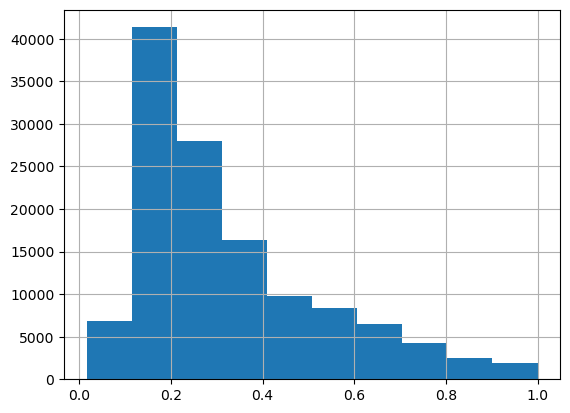

In [8]:
docking_info["similar.fp_similarity"].hist()

In [9]:
PandasTools.WriteSDF(
    docking_info[
        ~(
            (docking_info["docking.chemgauss_score"] > -16)
            & (docking_info["docking.posit_probability"] < 0.3)
        )
        & (docking_info["docking.chemgauss_score"] < 0)
    ].drop_duplicates(subset=["UniprotID", "compound_structures.canonical_smiles"]),
    "kinodata_docked_filtered.sdf.gz",
    molColName="molecule",
    properties=list(docking_info.columns),
    idName="RowID",
)

In [10]:
from matplotlib import pyplot as plt

In [11]:
docking_info = docking_info[(docking_info["docking.chemgauss_score"] < 0)]

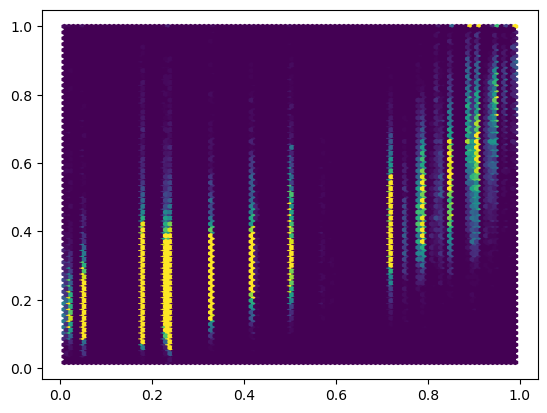

In [21]:
plt.hexbin(
    docking_info["docking.posit_probability"],
    docking_info["similar.fp_similarity"],
    vmax = 100,
    # s=1,
    # alpha=0.2,
)

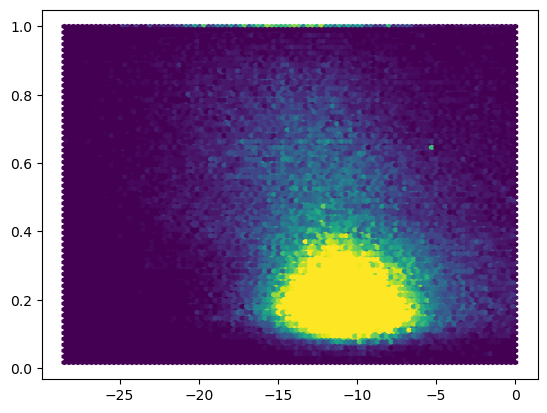

In [24]:
plt.hexbin(
    docking_info["docking.chemgauss_score"],
    docking_info["similar.fp_similarity"],
    vmax = 50,
)

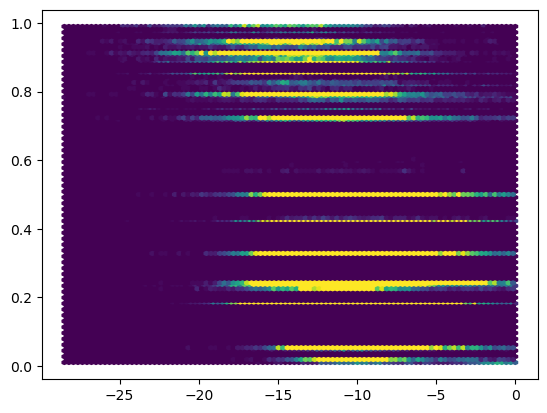

In [25]:
plt.hexbin(
    docking_info["docking.chemgauss_score"],
    docking_info["docking.posit_probability"],
    vmax = 50,
)